# Liver Disease Classification using Machine Learning

This notebook implements multiple machine learning algorithms to classify liver disease patients.

## Dataset Information
- **Features**: Age, Gender, Total Bilirubin, Direct Bilirubin, Alkaline Phosphotase, SGPT, SGOT, Total Proteins, Albumin, A/G Ratio
- **Target**: Result (1 = Liver Disease, 2 = No Liver Disease)


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Loading and Exploration


In [6]:
# Load the dataset with encoding handling
# Try different encodings to handle special characters
encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-8-sig']
df = None

for encoding in encodings:
    try:
        df = pd.read_csv('Liver Patient Dataset (LPD)_train.csv', encoding=encoding)
        print(f"Successfully loaded dataset using {encoding} encoding")
        break
    except (UnicodeDecodeError, UnicodeError):
        continue

if df is None:
    # Last resort: read with error handling
    df = pd.read_csv('Liver Patient Dataset (LPD)_train.csv', encoding='latin-1', errors='replace')
    print("Loaded dataset with error replacement")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()


Successfully loaded dataset using latin-1 encoding
Dataset Shape: (30691, 11)

First few rows:


,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result
0,65.0,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [7]:
# Clean column names (remove special characters and whitespace)
df.columns = df.columns.str.strip()
# Remove any special characters that might cause issues
df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)

# If column names don't match expected, assign new names
if len(df.columns) == 11:
    df.columns = ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                  'SGPT', 'SGOT', 'Total_Protiens', 'Albumin', 'A_G_Ratio', 'Result']
else:
    print(f"Warning: Expected 11 columns, got {len(df.columns)}")
    print("Current column names:", df.columns.tolist())

print("Column names cleaned!")
print("\nDataset Info:")
df.info()


Column names cleaned!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   30689 non-null  float64
 1   Gender                29789 non-null  object 
 2   Total_Bilirubin       30043 non-null  float64
 3   Direct_Bilirubin      30130 non-null  float64
 4   Alkaline_Phosphotase  29895 non-null  float64
 5   SGPT                  30153 non-null  float64
 6   SGOT                  30229 non-null  float64
 7   Total_Protiens        30228 non-null  float64
 8   Albumin               30197 non-null  float64
 9   A_G_Ratio             30132 non-null  float64
 10  Result                30691 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 2.6+ MB


In [8]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df)) * 100)


Missing Values:
Age                       2
Gender                  902
Total_Bilirubin         648
Direct_Bilirubin        561
Alkaline_Phosphotase    796
SGPT                    538
SGOT                    462
Total_Protiens          463
Albumin                 494
A_G_Ratio               559
Result                    0
dtype: int64

Missing Values Percentage:
Age                     0.006517
Gender                  2.938972
Total_Bilirubin         2.111368
Direct_Bilirubin        1.827897
Alkaline_Phosphotase    2.593594
SGPT                    1.752957
SGOT                    1.505327
Total_Protiens          1.508586
Albumin                 1.609592
A_G_Ratio               1.821381
Result                  0.000000
dtype: float64


In [9]:
# Statistical summary
print("Statistical Summary:")
df.describe()


Statistical Summary:


,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,SGPT,SGOT,Total_Protiens,Albumin,A_G_Ratio,Result
count,30689.000000,30043.000000,30130.000000,29895.000000,30153.000000,30229.000000,30228.000000,30197.000000,30132.000000,30691.000000
mean,44.107205,3.370319,1.528042,289.075364,81.488641,111.469979,6.480237,3.130142,0.943467,1.285882
std,15.981043,6.255522,2.869592,238.537589,182.158850,280.851078,1.081980,0.792281,0.323164,0.451841
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,32.000000,0.800000,0.200000,175.000000,23.000000,26.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,209.000000,35.000000,42.000000,6.600000,3.100000,0.900000,1.000000
75%,55.000000,2.700000,1.300000,298.000000,62.000000,88.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


## 2. Data Visualization - Dataset Exploration


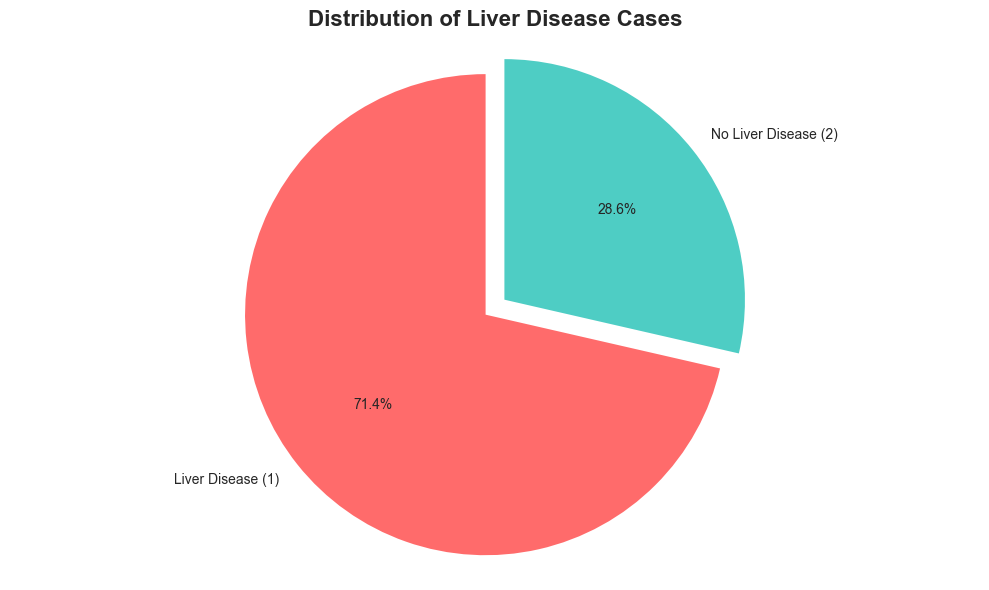

Target Distribution:
Result
1    21917
2     8774
Name: count, dtype: int64


In [10]:
# Target variable distribution
plt.figure(figsize=(10, 6))
target_counts = df['Result'].value_counts()
colors = ['#ff6b6b', '#4ecdc4']
plt.pie(target_counts.values, labels=['Liver Disease (1)', 'No Liver Disease (2)'], 
        autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0.05))
plt.title('Distribution of Liver Disease Cases', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("Target Distribution:")
print(target_counts)


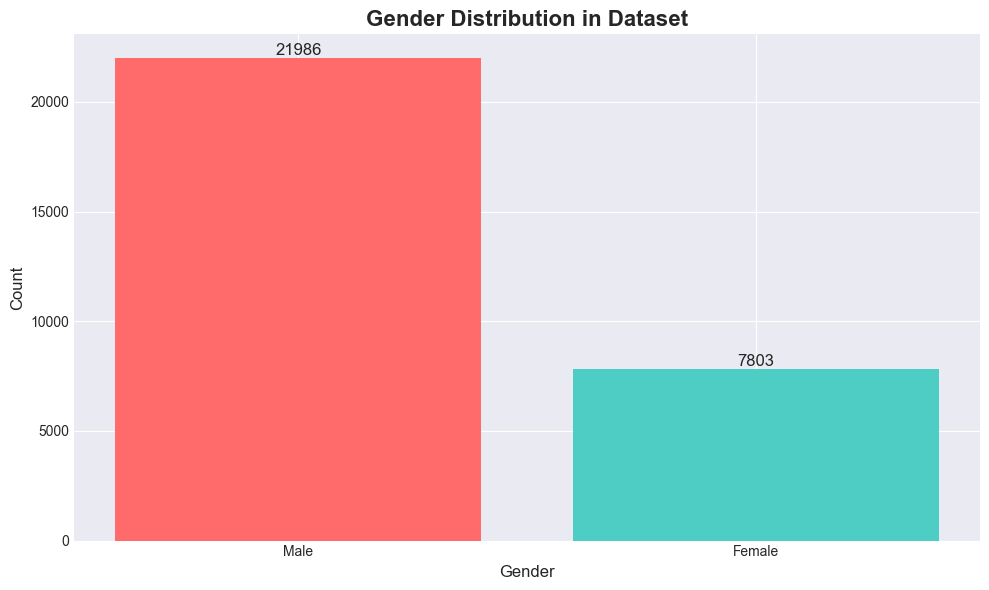

In [11]:
# Gender distribution
plt.figure(figsize=(10, 6))
gender_counts = df['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['#ff6b6b', '#4ecdc4', '#95e1d3'])
plt.title('Gender Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
for i, v in enumerate(gender_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


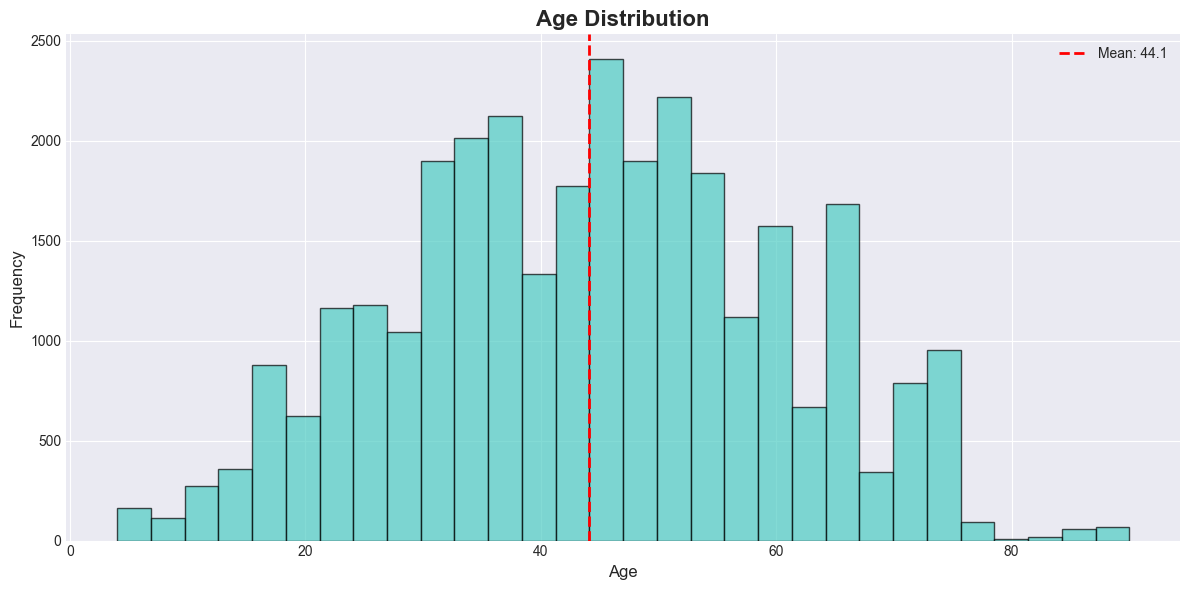

In [12]:
# Age distribution
plt.figure(figsize=(12, 6))
plt.hist(df['Age'].dropna(), bins=30, color='#4ecdc4', edgecolor='black', alpha=0.7)
plt.title('Age Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Age"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()


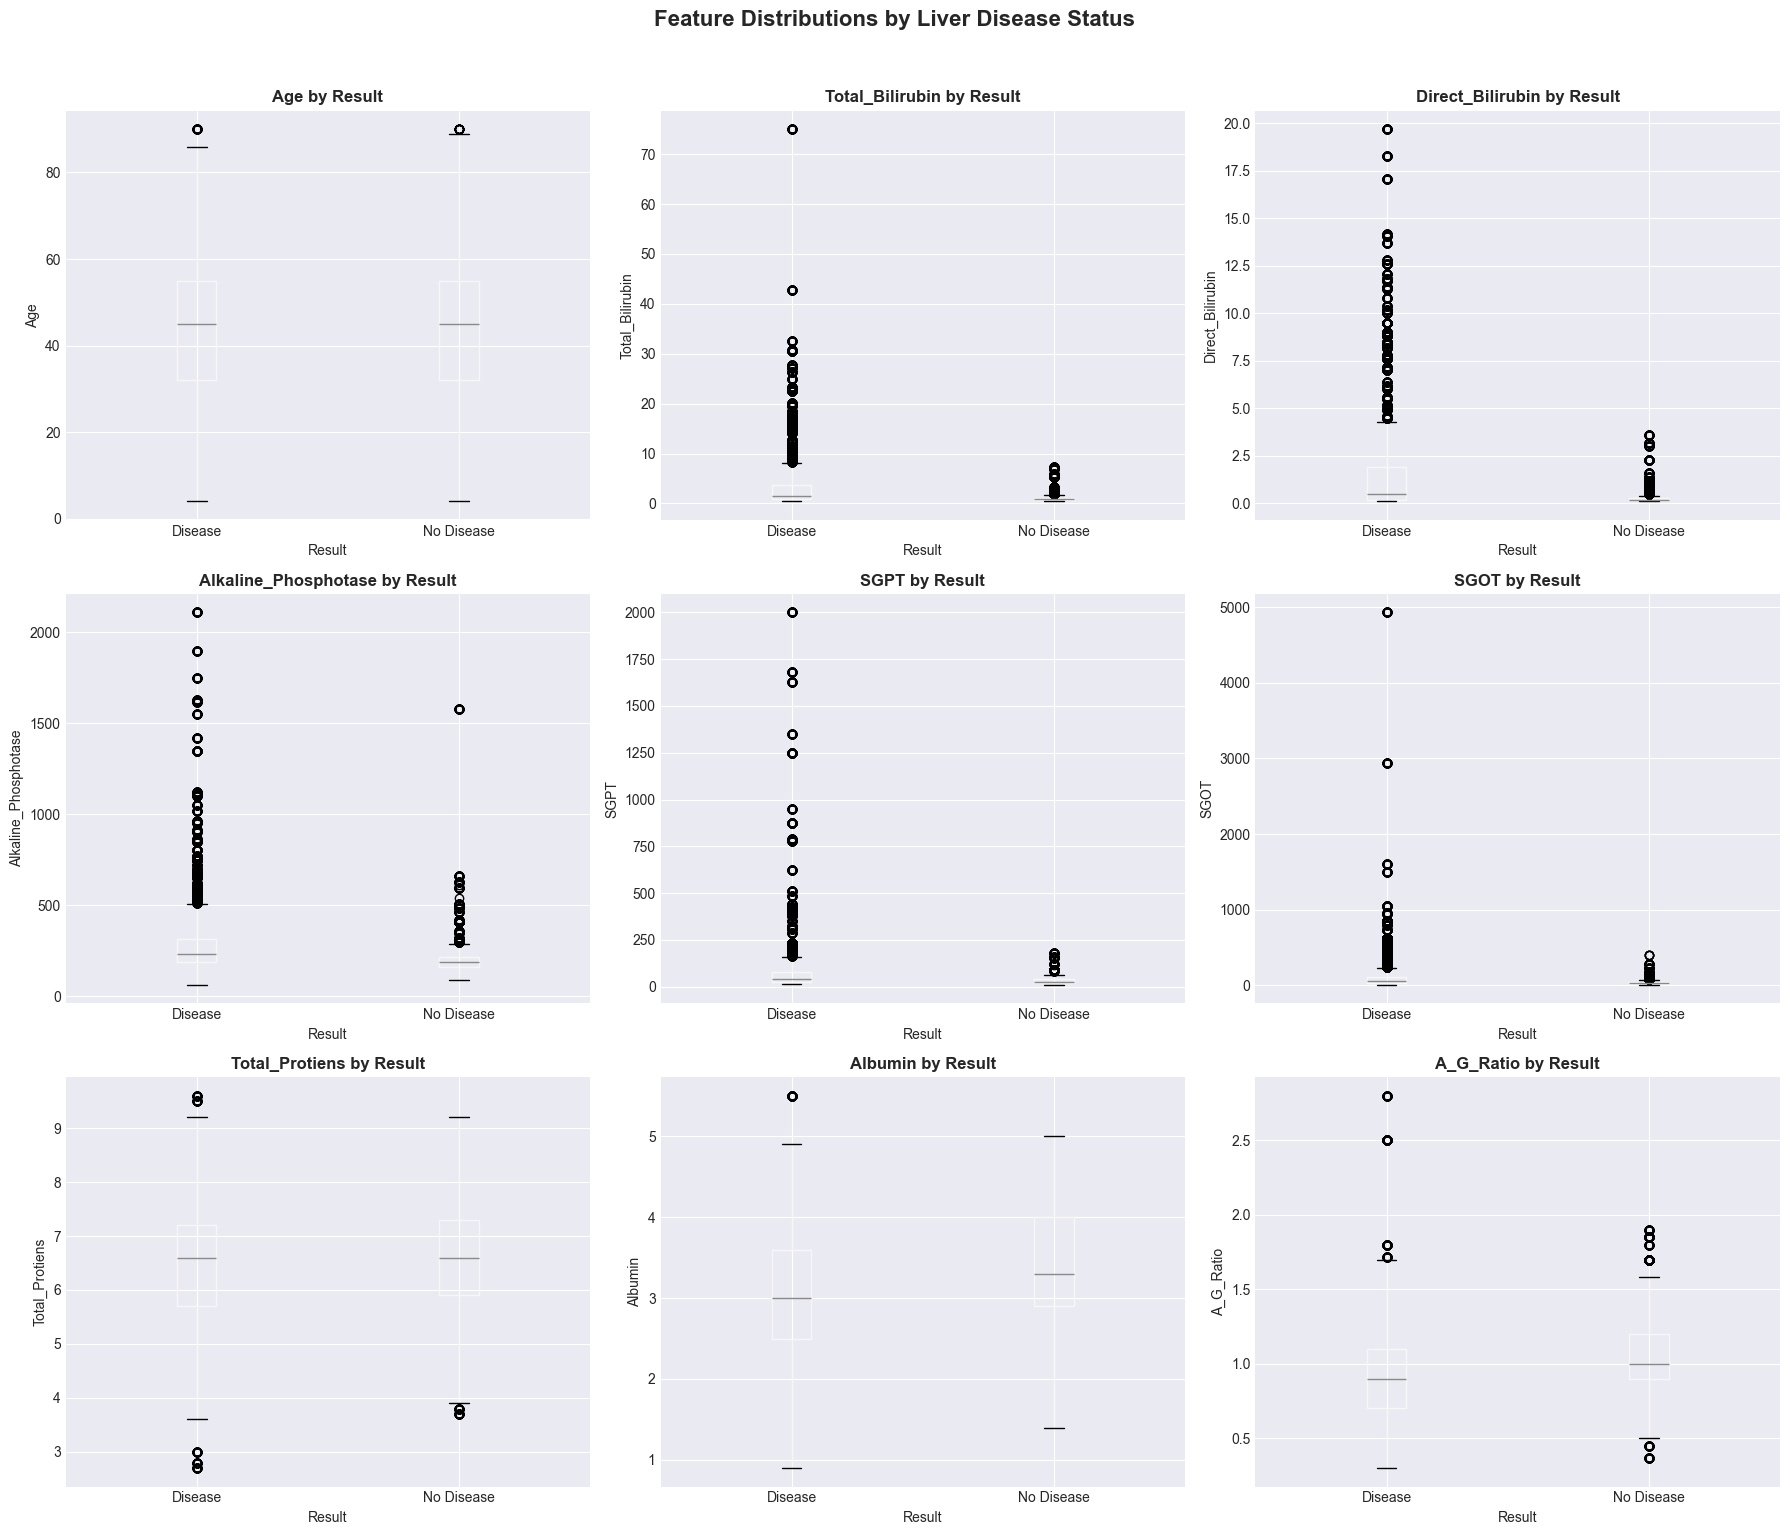

In [13]:
# Box plots for numerical features by Result
numerical_features = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                      'SGPT', 'SGOT', 'Total_Protiens', 'Albumin', 'A_G_Ratio']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    df_clean = df[[feature, 'Result']].dropna()
    df_clean.boxplot(column=feature, by='Result', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Result', fontweight='bold')
    axes[idx].set_xlabel('Result')
    axes[idx].set_ylabel(feature)
    axes[idx].set_xticklabels(['Disease', 'No Disease'])

plt.suptitle('Feature Distributions by Liver Disease Status', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


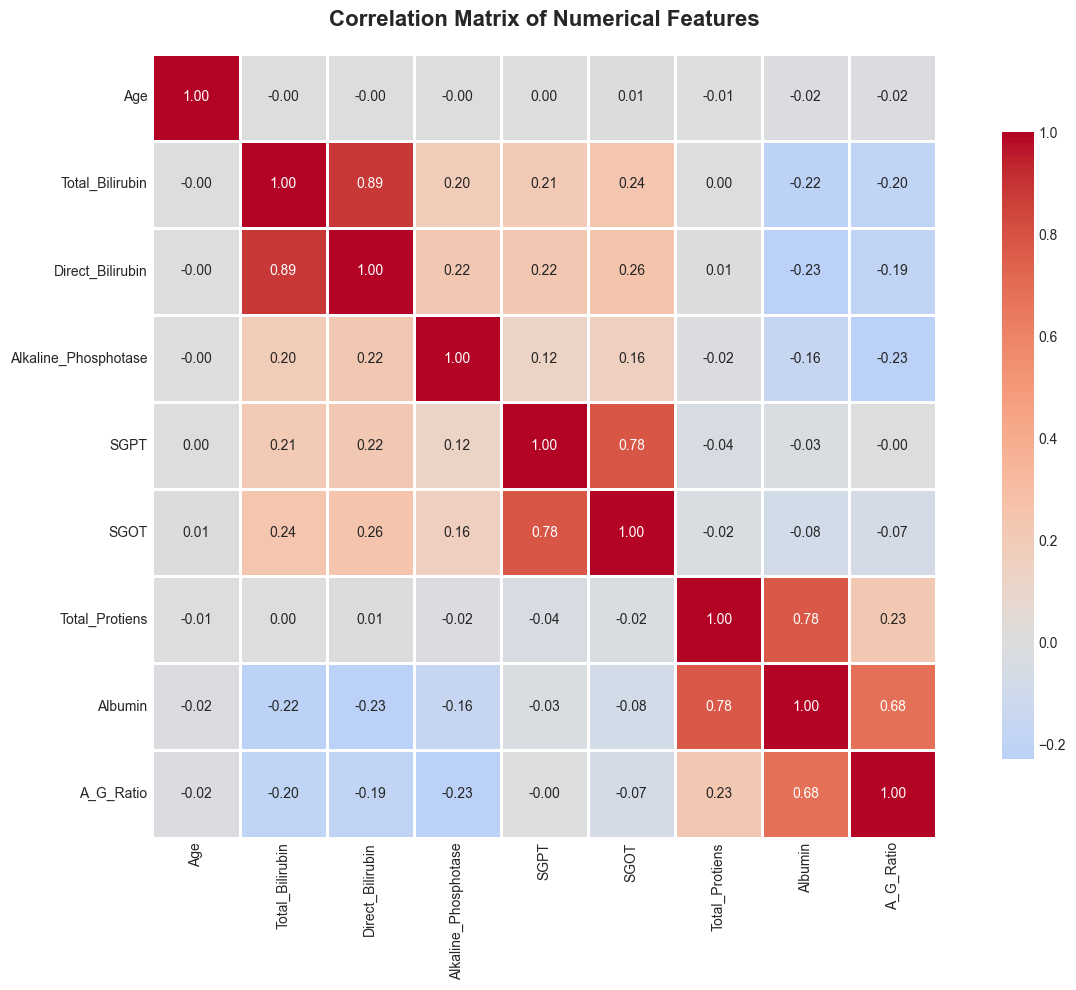

In [14]:
# Correlation matrix heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


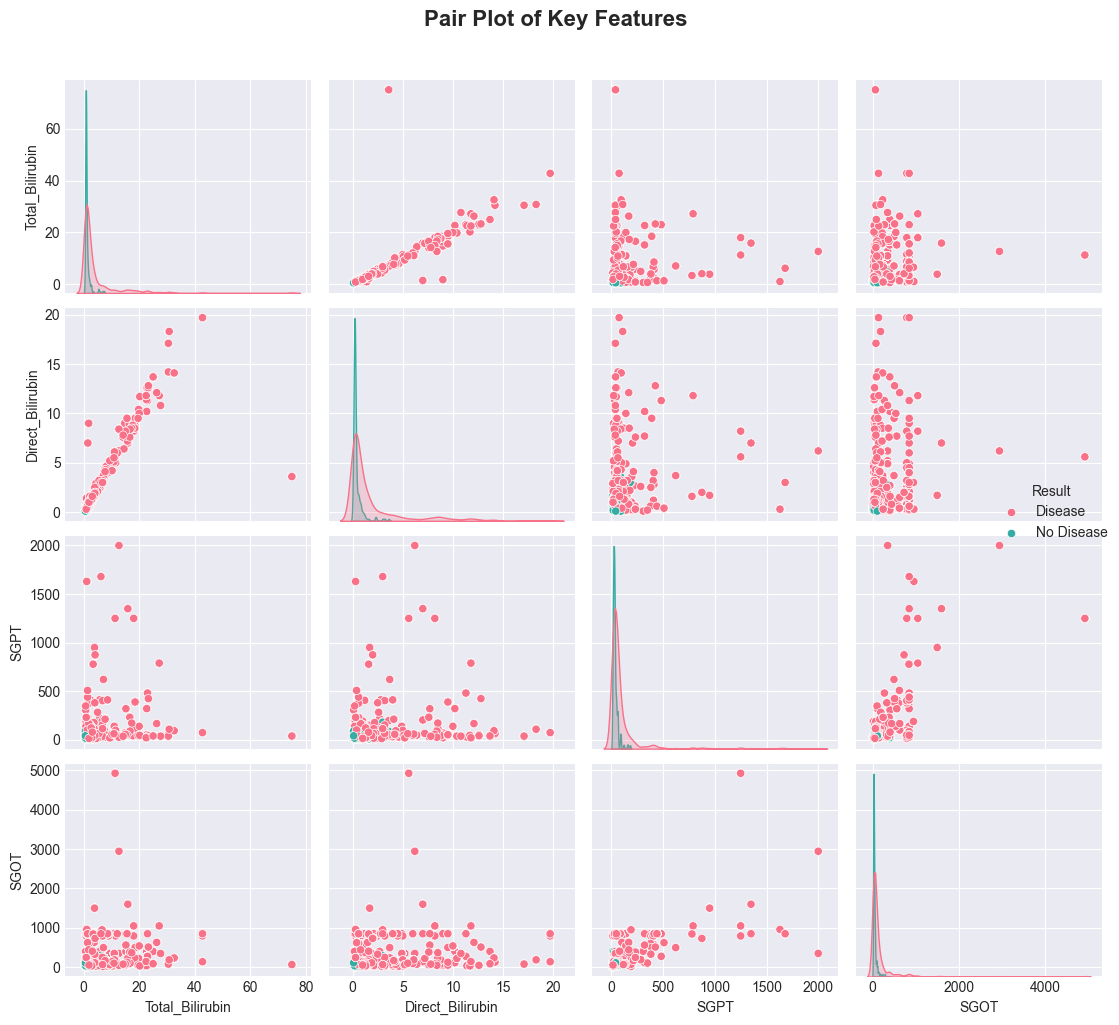

In [15]:
# Pair plot for key features
key_features = ['Total_Bilirubin', 'Direct_Bilirubin', 'SGPT', 'SGOT', 'Result']
df_pair = df[key_features].dropna()
df_pair['Result'] = df_pair['Result'].map({1: 'Disease', 2: 'No Disease'})

sns.pairplot(df_pair, hue='Result', diag_kind='kde', palette='husl', height=2.5)
plt.suptitle('Pair Plot of Key Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 3. Data Preprocessing


In [16]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values - fill with median for numerical columns
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if col != 'Result':
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Handle missing values in Gender - fill with mode
if df_processed['Gender'].isnull().any():
    df_processed['Gender'].fillna(df_processed['Gender'].mode()[0], inplace=True)

# Encode Gender (Male=1, Female=0)
le_gender = LabelEncoder()
df_processed['Gender_Encoded'] = le_gender.fit_transform(df_processed['Gender'])

# Convert Result: 1 = Disease (1), 2 = No Disease (0)
df_processed['Target'] = df_processed['Result'].map({1: 1, 2: 0})

# Select features
feature_columns = ['Age', 'Gender_Encoded', 'Total_Bilirubin', 'Direct_Bilirubin', 
                  'Alkaline_Phosphotase', 'SGPT', 'SGOT', 'Total_Protiens', 
                  'Albumin', 'A_G_Ratio']

X = df_processed[feature_columns]
y = df_processed['Target']

print("Data preprocessing completed!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nMissing values after preprocessing: {X.isnull().sum().sum()}")


Data preprocessing completed!
Features shape: (30691, 10)
Target shape: (30691,)

Missing values after preprocessing: 0


In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")


Train set size: (24552, 10)
Test set size: (6139, 10)

Train target distribution:
Target
1    17533
0     7019
Name: count, dtype: int64

Test target distribution:
Target
1    4384
0    1755
Name: count, dtype: int64


## 4. Model Training and Evaluation

We'll train multiple algorithms and compare their performance.


In [18]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Train and evaluate models
results = {}
predictions = {}
probabilities = {}

print("Training models...\n")

for name, model in models.items():
    # Train model
    if name in ['SVM', 'K-Nearest Neighbors', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_proba = None
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC: {roc_auc:.4f}")
    print()


Training models...

Logistic Regression:
  Accuracy: 0.7236
  Precision: 0.7407
  Recall: 0.9430
  F1-Score: 0.8297
  ROC-AUC: 0.7631

Random Forest:
  Accuracy: 0.9979
  Precision: 0.9984
  Recall: 0.9986
  F1-Score: 0.9985
  ROC-AUC: 1.0000

SVM:
  Accuracy: 0.7260
  Precision: 0.7272
  Recall: 0.9863
  F1-Score: 0.8372
  ROC-AUC: 0.8129

K-Nearest Neighbors:
  Accuracy: 0.9236
  Precision: 0.9424
  Recall: 0.9512
  F1-Score: 0.9468
  ROC-AUC: 0.9713

Naive Bayes:
  Accuracy: 0.5638
  Precision: 0.9616
  Recall: 0.4053
  F1-Score: 0.5703
  ROC-AUC: 0.7413

Decision Tree:
  Accuracy: 0.9917
  Precision: 0.9929
  Recall: 0.9954
  F1-Score: 0.9942
  ROC-AUC: 0.9889

Gradient Boosting:
  Accuracy: 0.8865
  Precision: 0.8710
  Recall: 0.9872
  F1-Score: 0.9255
  ROC-AUC: 0.9682

AdaBoost:
  Accuracy: 0.7179
  Precision: 0.8077
  Recall: 0.7940
  F1-Score: 0.8008
  ROC-AUC: 0.7770



In [19]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.round(4))


Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Random Forest          0.9979     0.9984  0.9986    0.9985   1.0000
Decision Tree          0.9917     0.9929  0.9954    0.9942   0.9889
K-Nearest Neighbors    0.9236     0.9424  0.9512    0.9468   0.9713
Gradient Boosting      0.8865     0.8710  0.9872    0.9255   0.9682
SVM                    0.7260     0.7272  0.9863    0.8372   0.8129
Logistic Regression    0.7236     0.7407  0.9430    0.8297   0.7631
AdaBoost               0.7179     0.8077  0.7940    0.8008   0.7770
Naive Bayes            0.5638     0.9616  0.4053    0.5703   0.7413


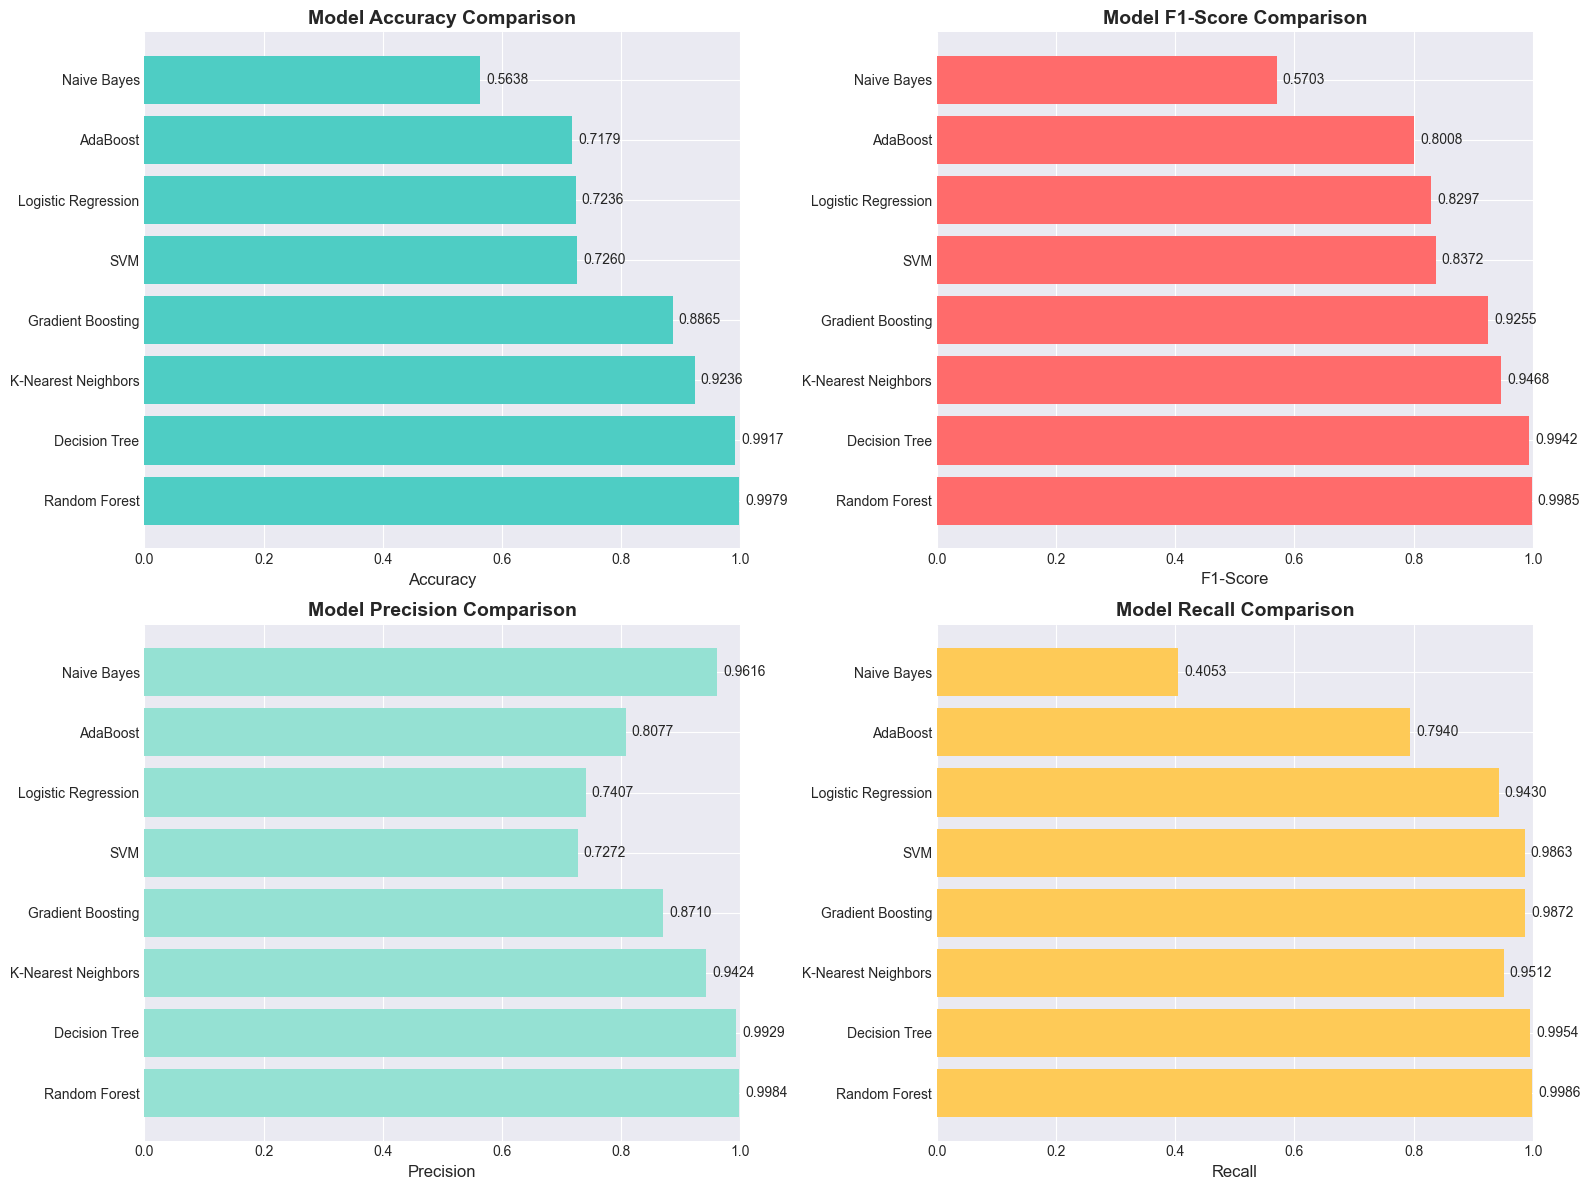

In [20]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0, 0].barh(comparison_df.index, comparison_df['Accuracy'], color='#4ecdc4')
axes[0, 0].set_xlabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# F1-Score comparison
axes[0, 1].barh(comparison_df.index, comparison_df['F1-Score'], color='#ff6b6b')
axes[0, 1].set_xlabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
for i, v in enumerate(comparison_df['F1-Score']):
    axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# Precision comparison
axes[1, 0].barh(comparison_df.index, comparison_df['Precision'], color='#95e1d3')
axes[1, 0].set_xlabel('Precision', fontsize=12)
axes[1, 0].set_title('Model Precision Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim([0, 1])
for i, v in enumerate(comparison_df['Precision']):
    axes[1, 0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# Recall comparison
axes[1, 1].barh(comparison_df.index, comparison_df['Recall'], color='#feca57')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_title('Model Recall Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim([0, 1])
for i, v in enumerate(comparison_df['Recall']):
    axes[1, 1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


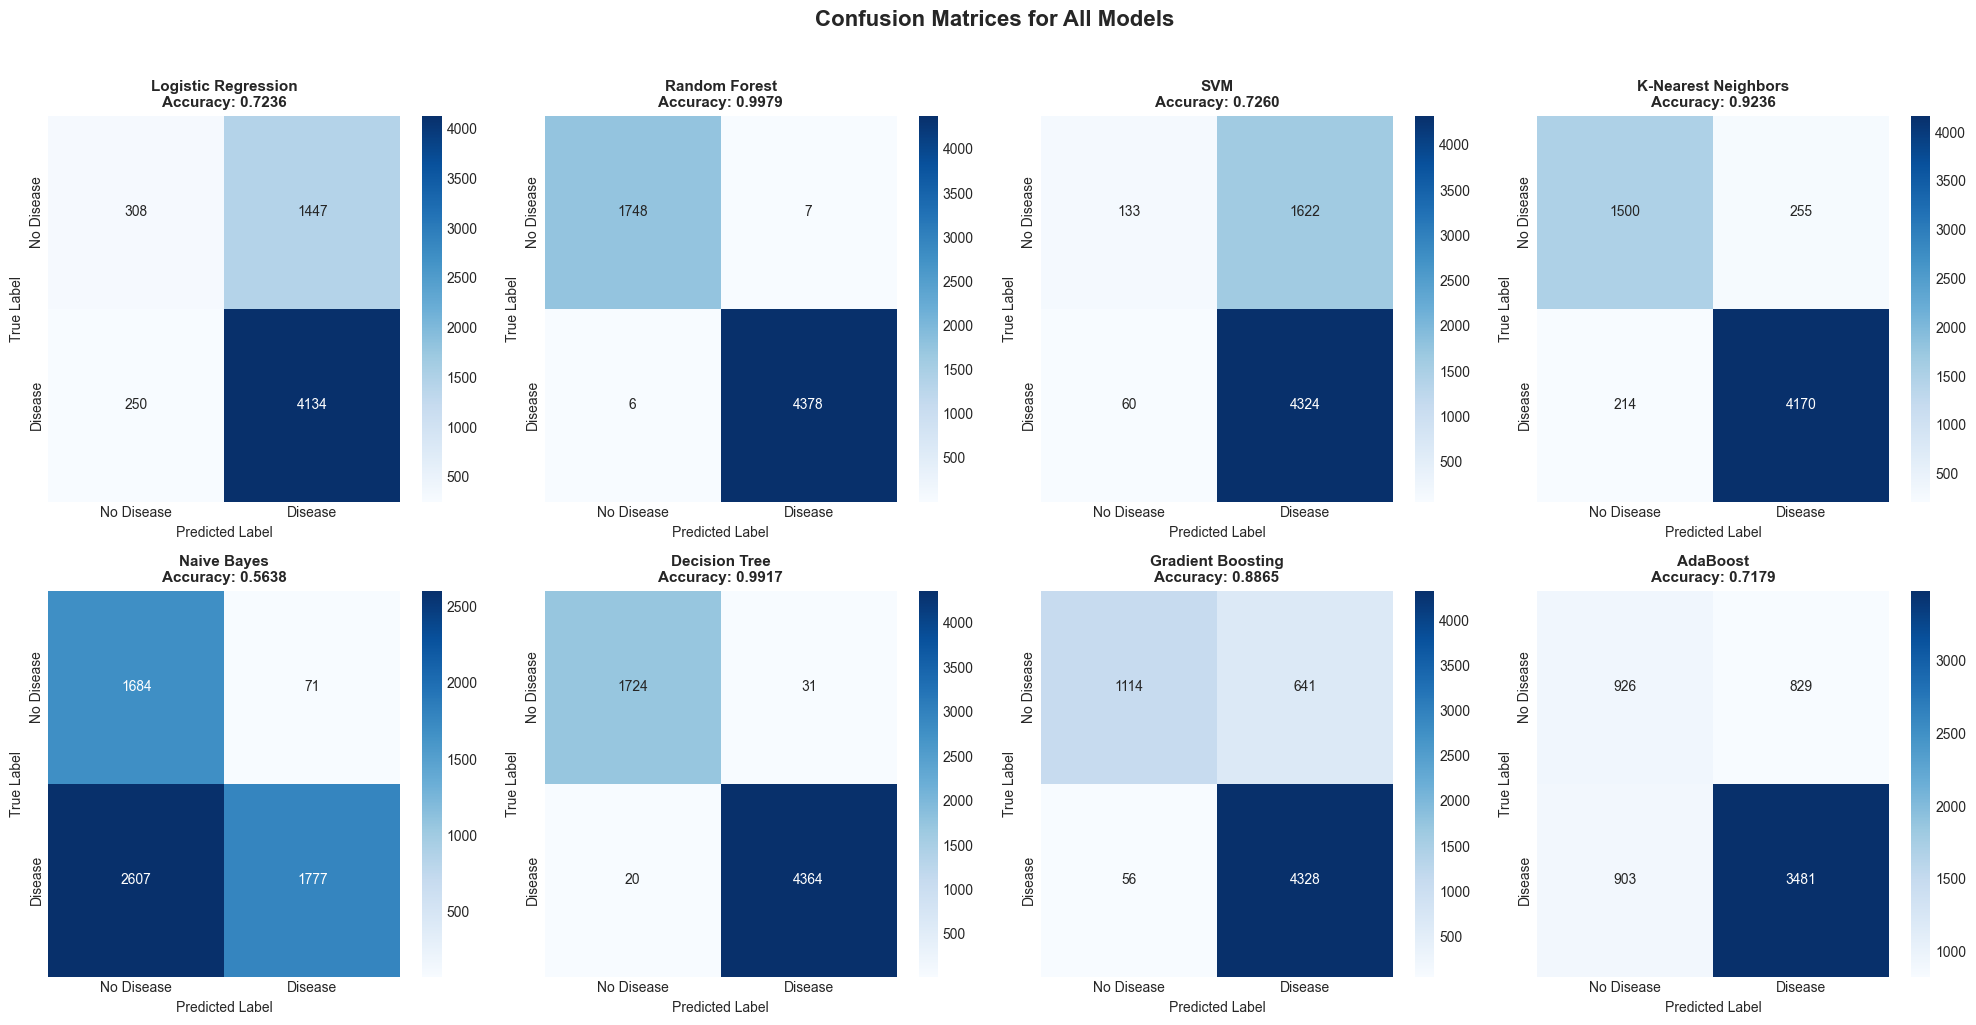

In [21]:
# Confusion Matrices for all models
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['No Disease', 'Disease'], 
                yticklabels=['No Disease', 'Disease'])
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["Accuracy"]:.4f}', 
                        fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

plt.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


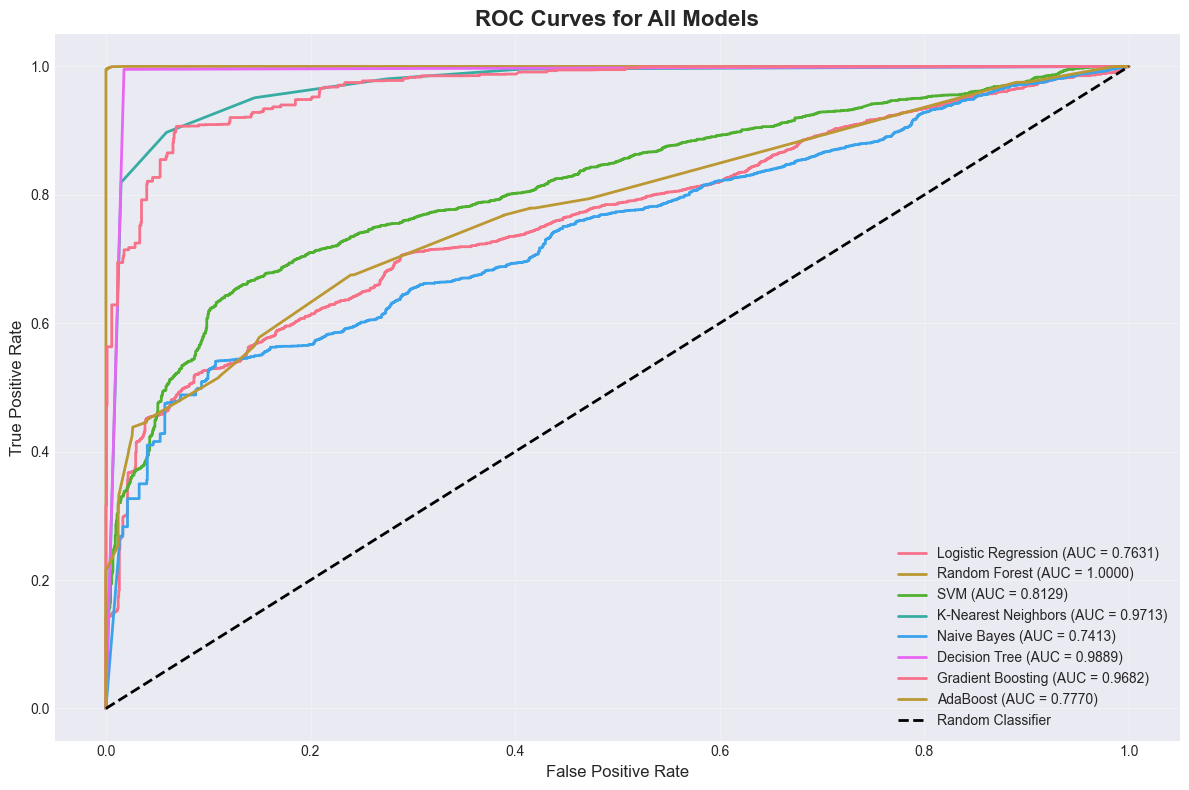

In [22]:
# ROC Curves for models with probability predictions
fig, ax = plt.subplots(figsize=(12, 8))

models_with_proba = ['Logistic Regression', 'Random Forest', 'SVM', 'K-Nearest Neighbors', 
                     'Naive Bayes', 'Decision Tree', 'Gradient Boosting', 'AdaBoost']

for name in models_with_proba:
    if probabilities[name] is not None:
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves for All Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


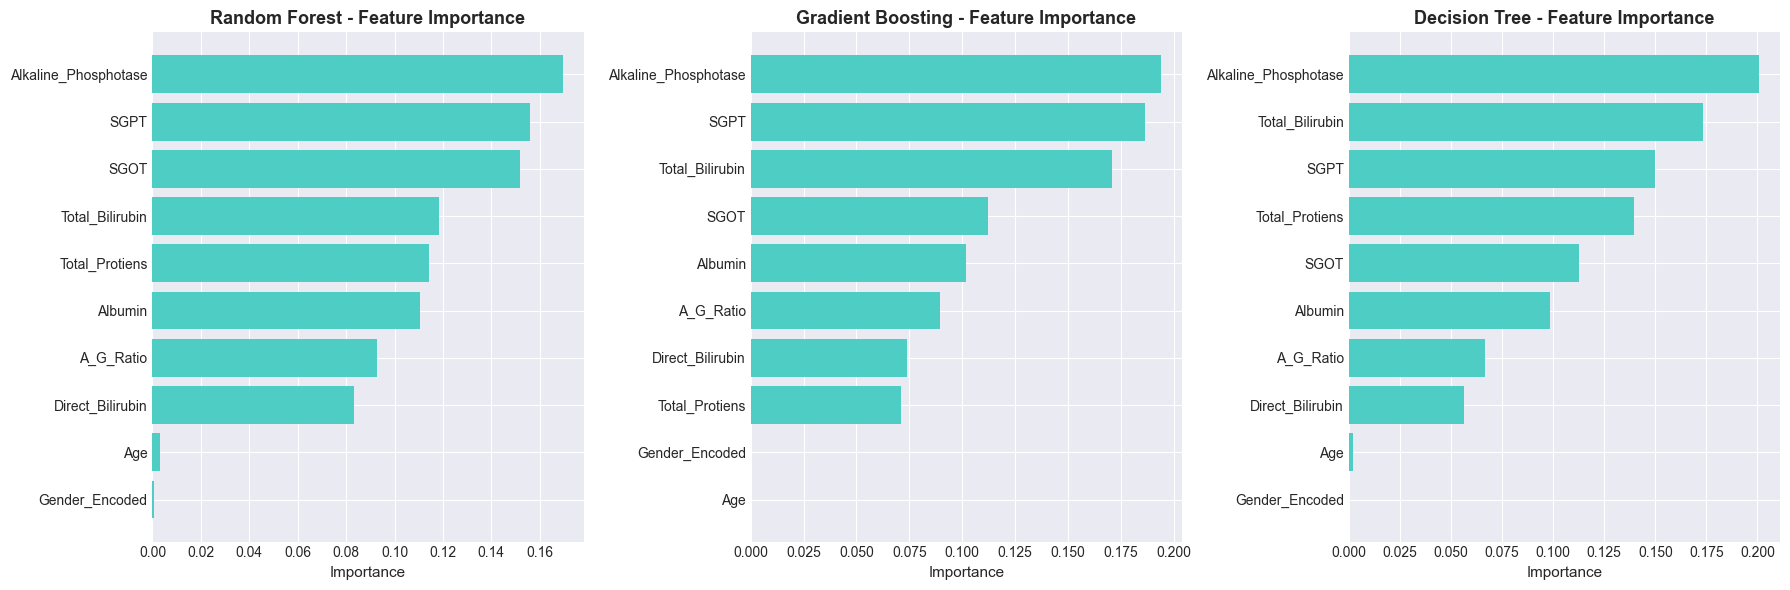

In [23]:
# Feature importance for tree-based models
tree_models = {
    'Random Forest': models['Random Forest'],
    'Gradient Boosting': models['Gradient Boosting'],
    'Decision Tree': models['Decision Tree']
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, model) in enumerate(tree_models.items()):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        axes[idx].barh(range(len(feature_columns)), importances[indices], color='#4ecdc4')
        axes[idx].set_yticks(range(len(feature_columns)))
        axes[idx].set_yticklabels([feature_columns[i] for i in indices])
        axes[idx].set_xlabel('Importance', fontsize=11)
        axes[idx].set_title(f'{name} - Feature Importance', fontsize=13, fontweight='bold')
        axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()


In [24]:
# Cross-validation scores
cv_results = {}
print("Performing 5-fold cross-validation...\n")

for name, model in models.items():
    if name in ['SVM', 'K-Nearest Neighbors', 'Logistic Regression']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    cv_results[name] = {
        'Mean': cv_scores.mean(),
        'Std': cv_scores.std()
    }
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values('Mean', ascending=False)


Performing 5-fold cross-validation...

Logistic Regression: 0.7235 (+/- 0.0045)
Random Forest: 0.9978 (+/- 0.0018)
SVM: 0.7275 (+/- 0.0012)
K-Nearest Neighbors: 0.9008 (+/- 0.0063)
Naive Bayes: 0.5613 (+/- 0.0084)
Decision Tree: 0.9919 (+/- 0.0025)
Gradient Boosting: 0.8817 (+/- 0.0149)
AdaBoost: 0.7212 (+/- 0.0181)


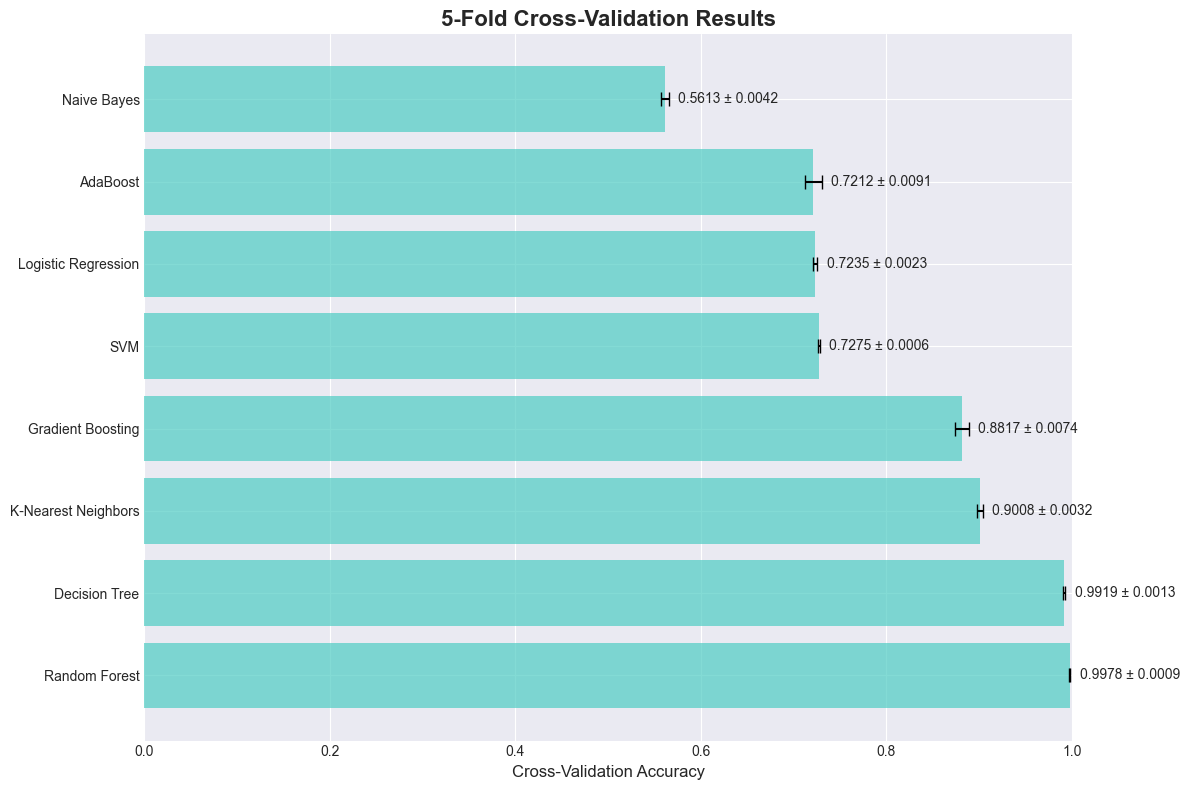

In [25]:
# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(12, 8))
x_pos = np.arange(len(cv_df))
bars = ax.barh(x_pos, cv_df['Mean'], xerr=cv_df['Std'], capsize=5, color='#4ecdc4', alpha=0.7)
ax.set_yticks(x_pos)
ax.set_yticklabels(cv_df.index)
ax.set_xlabel('Cross-Validation Accuracy', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')
ax.set_xlim([0, 1])

for i, (mean, std) in enumerate(zip(cv_df['Mean'], cv_df['Std'])):
    ax.text(mean + std + 0.01, i, f'{mean:.4f} ± {std:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [26]:
# Detailed classification report for the best model
best_model_name = comparison_df.index[0]
best_model = models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"Detailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, best_predictions, 
                          target_names=['No Disease', 'Disease']))
print("=" * 60)


Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

  No Disease       1.00      1.00      1.00      1755
     Disease       1.00      1.00      1.00      4384

    accuracy                           1.00      6139
   macro avg       1.00      1.00      1.00      6139
weighted avg       1.00      1.00      1.00      6139



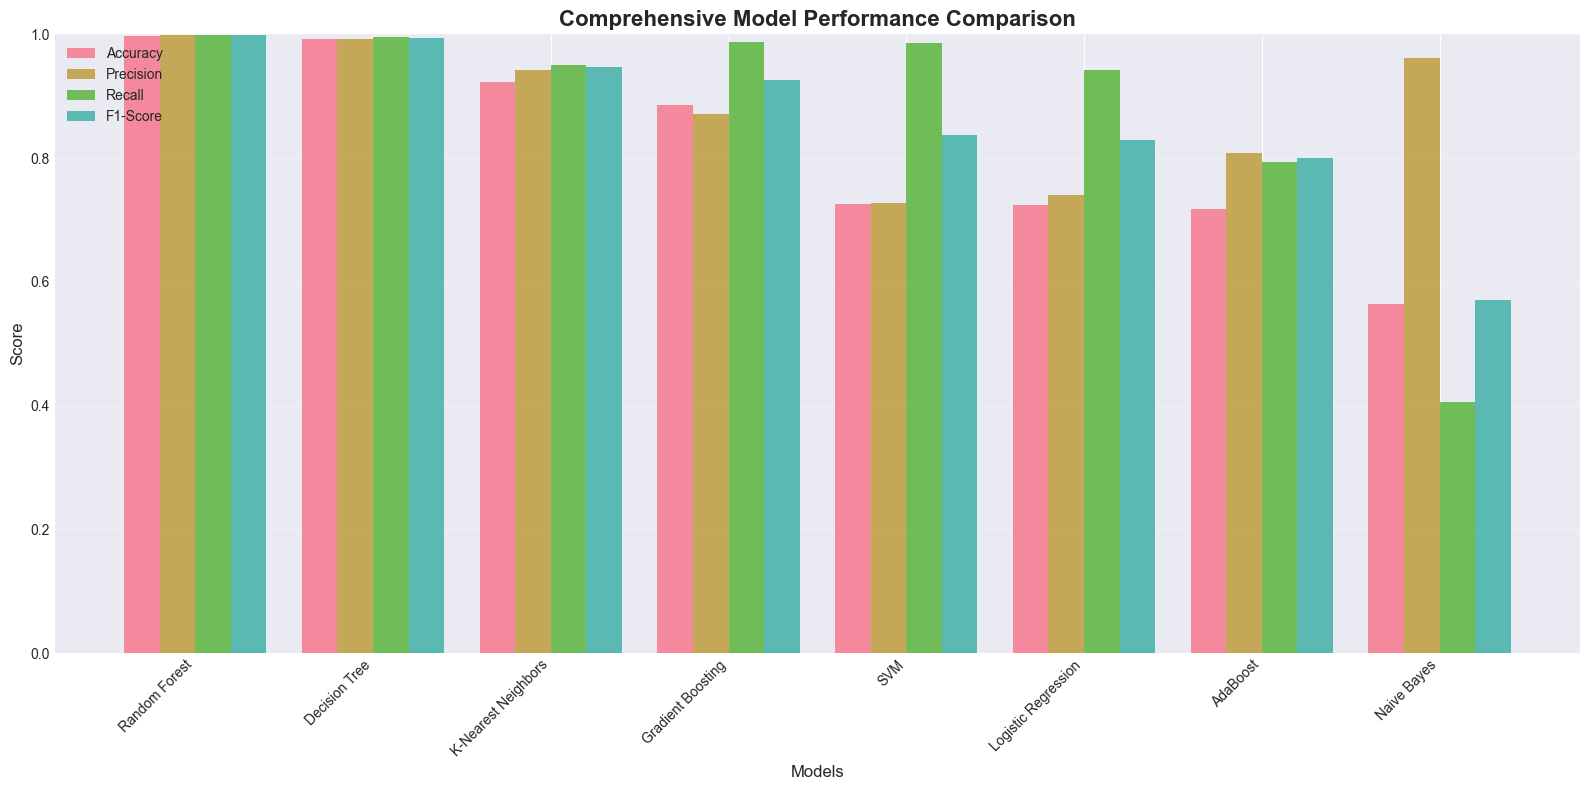

In [27]:
# Performance metrics comparison chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df.index))
width = 0.2

fig, ax = plt.subplots(figsize=(16, 8))
for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    ax.bar(x + offset, comparison_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Summary and Conclusions

### Best Performing Model
Based on the evaluation metrics, the best performing model is identified above.

### Key Findings:
1. **Dataset Characteristics**: The dataset contains liver disease indicators with various biochemical parameters.
2. **Model Performance**: Multiple algorithms were tested and their performance was compared.
3. **Feature Importance**: Key features contributing to liver disease prediction were identified.

### Recommendations:
- The best model can be used for liver disease prediction
- Further hyperparameter tuning can improve performance
- Feature engineering might enhance model accuracy
